In [1]:
import pandas as pd
from sklearn.model_selection import train_test_split

# Cargar'base_de_datos_1.csv'
df = pd.read_csv('/content/datos.csv', delimiter=';')

# Mostras base de datos
print(df.head())

   Unnamed: 0 Descripcion_Area_Rural   Furips_Descripcion        Ciudad  \
0           0                  RURAL  se estrelló de novi  BARRANQUILLA   
1           1                  RURAL  se estrelló de novi  BARRANQUILLA   
2           2                  RURAL  se estrelló de novi  BARRANQUILLA   
3           3                  RURAL  se estrelló de novi  BARRANQUILLA   
4           4                  RURAL  se estrelló de novi  BARRANQUILLA   

  Marca_Vehiculo Estado_Vehiculo_Descripcion Tipo_Vehiculo_Descripcion  \
0        reanaul                   Asegurado                Particular   
1        reanaul                   Asegurado                Particular   
2        reanaul                   Asegurado                Particular   
3        reanaul                   Asegurado                Particular   
4        reanaul                   Asegurado                Particular   

  Tipo_Vehiculo Condicion_Accidentado_Descripcion  \
0     Automovil                          Ocupante  

In [2]:
!pip install keras-tuner

from keras_tuner import Objective
import tensorflow as tf
from sklearn.metrics import f1_score
import pandas as pd
import numpy as np
import gensim
from gensim.utils import simple_preprocess
from gensim.parsing.preprocessing import STOPWORDS
from gensim import corpora, models
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import Dense, Dropout, BatchNormalization
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.optimizers import Adam
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.utils.class_weight import compute_class_weight
from imblearn.over_sampling import SMOTE
from keras_tuner import RandomSearch, HyperModel
from tensorflow.keras.regularizers import l1_l2
from tensorflow.keras.metrics import Precision, Recall
from keras_tuner.engine import hyperparameters as hp
from sklearn.metrics import f1_score

# Preprocesamiento de texto para LDA
def preprocess_text(text):
    result = []
    for token in simple_preprocess(text):
        if token not in STOPWORDS and len(token) > 3:
            result.append(token)
    return result

# Este fragmento de código prepara un conjunto de datos para análisis de tópicos con LDA, combinando dos columnas de texto, preprocesándolas, y luego construyendo un modelo LDA con 44 temas utilizando Gensim.
df['text_for_lda'] = df['Furips_Descripcion'].astype(str) + ' ' + df['Categoria_Descripcion_Eje10'].astype(str)
documents = df['text_for_lda'].map(preprocess_text)

dictionary = corpora.Dictionary(documents)
corpus = [dictionary.doc2bow(text) for text in documents]

num_topics = 44
lda_model = gensim.models.LdaMulticore(corpus, num_topics=num_topics, id2word=dictionary, passes=20, workers=2)

# Convertir los documentos a vectores de temas
ldafeatures = [lda_model[doc] for doc in corpus]
lda_features_matrix = np.array([[dict(doc).get(i, 0) for i in range(num_topics)] for doc in ldafeatures])

# One-hot encoding para variables categóricas
categorical_vars = ['Descripcion_Area_Rural', 'Ciudad', 'Marca_Vehiculo', 'Estado_Vehiculo_Descripcion', 'Tipo_Vehiculo_Descripcion', 'Tipo_Vehiculo', 'Condicion_Accidentado_Descripcion']
df_cat = pd.get_dummies(df[categorical_vars])

# Concatenar las características categóricas con las características LDA
X = np.hstack((df_cat.values, lda_features_matrix))

# Codificación de la variable objetivo
le = LabelEncoder()
y = le.fit_transform(df['Fraude'].values)

# División en conjuntos de entrenamiento y prueba
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Aplicación de SMOTE
smote = SMOTE(sampling_strategy=0.7, random_state=42)
X_train_smote, y_train_smote = smote.fit_resample(X_train, y_train)



# Se define una métrica F1 personalizada para evaluar el rendimiento de un modelo de clasificación binaria en TensorFlow
def f1_metric(y_true, y_pred):
    y_pred = tf.round(y_pred)  # Convertir predicciones a 0 o 1
    tp = tf.reduce_sum(tf.cast(y_true * y_pred, dtype=tf.float32))  # Verdaderos positivos
    fp = tf.reduce_sum(tf.cast((1 - y_true) * y_pred, dtype=tf.float32))  # Falsos positivos
    fn = tf.reduce_sum(tf.cast(y_true * (1 - y_pred), dtype=tf.float32))  # Falsos negativos

    precision = tp / (tp + fp + tf.keras.backend.epsilon())
    recall = tp / (tp + fn + tf.keras.backend.epsilon())

    f1 = 2*precision*recall / (precision + recall + tf.keras.backend.epsilon())
    return f1


# Calculando pesos de clase para manejar desequilibrios
weights = compute_class_weight('balanced', classes=np.unique(y_train_smote), y=y_train_smote)
class_weights = dict(enumerate(weights))

# Definición de la clase HyperModel para la red neuronal
class NeuralNetworkHyperModel(HyperModel):
    def __init__(self, input_shape):
        self.input_shape = input_shape

    def build(self, hp):
        model = Sequential()
        model.add(Dense(units=hp.Int('units_1', min_value=64, max_value=512, step=64),
                        activation='relu',
                        kernel_regularizer=l1_l2(l1=hp.Float('l1_1', min_value=1e-5, max_value=1e-2, sampling='LOG'),
                                                 l2=hp.Float('l2_1', min_value=1e-5, max_value=1e-2, sampling='LOG')),
                        input_shape=(self.input_shape,)))
        model.add(BatchNormalization())
        model.add(Dropout(rate=hp.Float('dropout_1', min_value=0, max_value=0.5, step=0.1)))

        for i in range(hp.Int('num_layers', 1, 3)):
            model.add(Dense(units=hp.Int(f'units_{i+2}', min_value=64, max_value=512, step=64),
                            activation='relu',
                            kernel_regularizer=l1_l2(l1=hp.Float(f'l1_{i+2}', min_value=1e-5, max_value=1e-2, sampling='LOG'),
                                                     l2=hp.Float(f'l2_{i+2}', min_value=1e-5, max_value=1e-2, sampling='LOG'))))
            model.add(BatchNormalization())
            model.add(Dropout(rate=hp.Float(f'dropout_{i+2}', min_value=0, max_value=0.5, step=0.1)))

        model.add(Dense(1, activation='sigmoid'))
        # Recompilar el modelo con los mejores hiperparámetros
        model.compile(optimizer=Adam(hp.Float('learning_rate', min_value=1e-5, max_value=1e-2, sampling='LOG')),
                      loss='binary_crossentropy',
                      metrics=['accuracy', Precision(name='precision'), Recall(name='recall'), f1_metric])

        return model

input_shape = X_train_smote.shape[1]
hypermodel = NeuralNetworkHyperModel(input_shape)

# Inicialización de Keras Tuner con métrica personalizada para el F1-score
tuner = RandomSearch(
    hypermodel,
    objective=Objective('val_f1_metric', direction='max'),  # Cambiado a 'val_f1_metric'
    max_trials=30,
    executions_per_trial=2,
    directory='random_search',
    project_name='FraudeDetectionOptimized',
    overwrite=True
)

# Callbacks
early_stopping = EarlyStopping(monitor='val_loss', patience=10, mode='min', restore_best_weights=True)
model_checkpoint = ModelCheckpoint('best_model.h5', monitor='val_f1_metric', save_best_only=True, mode='max', verbose=1)  # Cambiado a 'val_f1_metric'

# Búsqueda
tuner.search(X_train_smote, y_train_smote,
             epochs=50,
             validation_data=(X_test, y_test),
             class_weight=class_weights,
             callbacks=[early_stopping, model_checkpoint])

# Mostrar los mejores hiperparámetros
best_hyperparameters = tuner.get_best_hyperparameters(num_trials=1)[0]
print(f"Best hyperparameters: {best_hyperparameters}")

# Recompilar el modelo con los mejores hiperparámetros
model = tuner.hypermodel.build(best_hyperparameters)

# Compilar el modelo con métricas personalizadas
model.compile(optimizer=Adam(best_hyperparameters.get('learning_rate')),
              loss='binary_crossentropy',
              metrics=[f1_metric, 'accuracy'])  # Agregar métrica 'accuracy'

# Entrenamiento del modelo con datos de validación
history = model.fit(X_train_smote, y_train_smote,
                    epochs=100,
                    validation_data=(X_test, y_test),
                    class_weight=class_weights,
                    callbacks=[early_stopping, model_checkpoint])






Trial 30 Complete [00h 02m 12s]
val_f1_metric: 0.2916994243860245

Best val_f1_metric So Far: 0.47768227756023407
Total elapsed time: 03h 31m 15s
Best hyperparameters: <keras_tuner.src.engine.hyperparameters.hyperparameters.HyperParameters object at 0x7ae3e3062b90>
Epoch 1/100
577/580 [============================>.] - ETA: 0s - loss: 1.7925 - f1_metric: 0.5826 - accuracy: 0.6039
Epoch 1: val_f1_metric improved from -inf to 0.30756, saving model to best_model.h5
580/580 [==============================] - 7s 8ms/step - loss: 1.7918 - f1_metric: 0.5824 - accuracy: 0.6038 - val_loss: 1.6153 - val_f1_metric: 0.3076 - val_accuracy: 0.5642
Epoch 2/100
578/580 [============================>.] - ETA: 0s - loss: 1.4847 - f1_metric: 0.6511 - accuracy: 0.6749
Epoch 2: val_f1_metric improved from 0.30756 to 0.33288, saving model to best_model.h5
580/580 [==============================] - 4s 7ms/step - loss: 1.4848 - f1_metric: 0.6503 - accuracy: 0.6743 - val_loss: 1.4447 - val_f1_metric: 0.3329 - 

99/99 [==============================] - 0s 3ms/step
Precisión de la Red Neuronal: 80.29%
Reporte de clasificación de la Red Neuronal:
              precision    recall  f1-score   support

           0       0.96      0.80      0.88      2758
           1       0.37      0.79      0.50       397

    accuracy                           0.80      3155
   macro avg       0.67      0.80      0.69      3155
weighted avg       0.89      0.80      0.83      3155



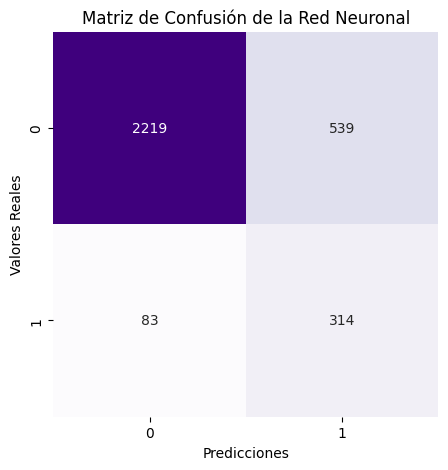

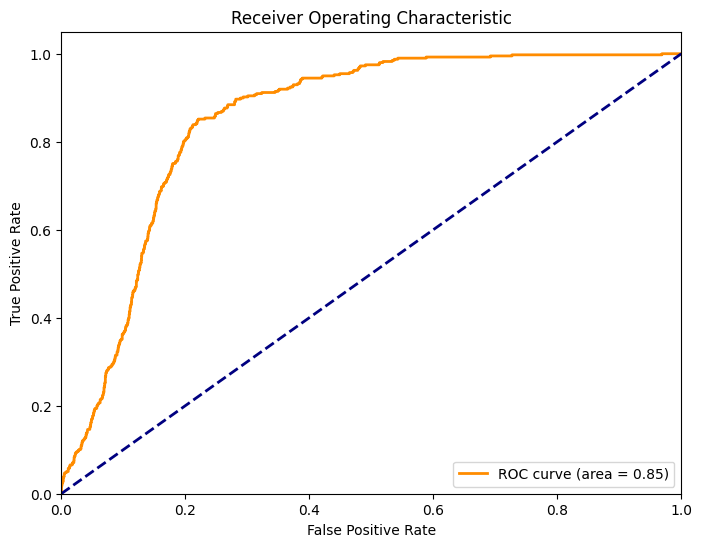

AUC: 0.85


In [9]:
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import roc_curve, auc
from tensorflow.keras.models import Sequential, load_model


# Cargar el mejor modelo guardado con custom_objects para la función de métrica
model = load_model('best_model.h5', custom_objects={'f1_metric': f1_metric})

# Hacer predicciones con el conjunto de prueba
nn_predictions_prob = model.predict(X_test)
nn_predictions = (nn_predictions_prob > 0.5).astype(int)

# Calcular la precisión
nn_accuracy = accuracy_score(y_test, nn_predictions)
print(f'Precisión de la Red Neuronal: {nn_accuracy * 100:.2f}%')

# Reporte de clasificación
print("Reporte de clasificación de la Red Neuronal:")
print(classification_report(y_test, nn_predictions))

# Matriz de confusión
cm_nn = confusion_matrix(y_test, nn_predictions)
plt.figure(figsize=(5,5))
sns.heatmap(cm_nn, annot=True, fmt="d", cmap="Purples", square=True, cbar=False)
plt.xlabel('Predicciones')
plt.ylabel('Valores Reales')
plt.title('Matriz de Confusión de la Red Neuronal')
plt.show()

# Cálculo de las tasas de verdaderos positivos (TPR), falsos positivos (FPR), y el área bajo la curva (AUC)
fpr, tpr, thresholds = roc_curve(y_test, nn_predictions_prob[:, 0])
roc_auc = auc(fpr, tpr)

# Dibujar la curva ROC
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()

# Imprimir el AUC
print(f'AUC: {roc_auc:.2f}')